# Testing with generated complex data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

Generate a dataset.

coef = 1.0


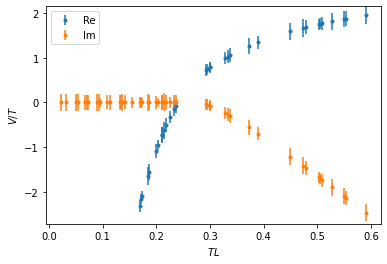

In [2]:
dataset = AdSBHDataset(N=50, threshold=0.0, coef=1.0)
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend()
print(f'coef = {dataset.coef}')

## Consistency check
Learnable parameters set to zero (standard BH).

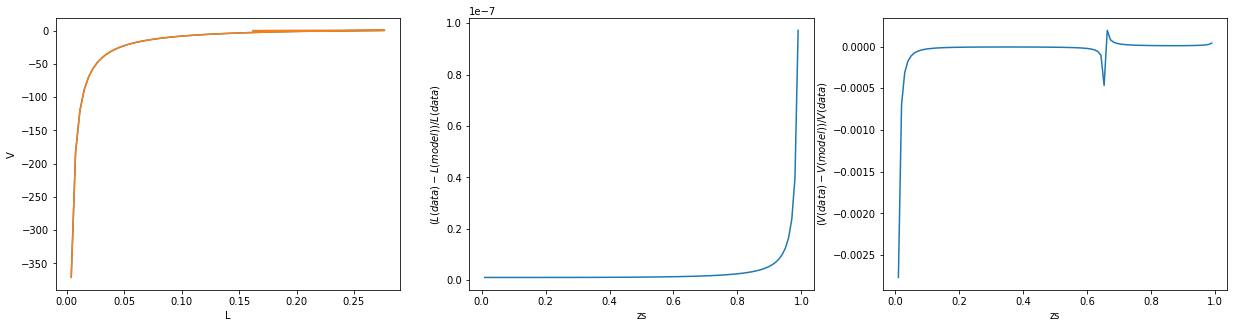

In [3]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
zs = np.linspace(0.01, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$');

Agreement between dataset and model is reasonable with zero parameters. How about with some random parameters?

In [4]:
zsTest = [complex(0.5140773201571425,0.6088586260994207), complex(0.24682691472024243,0.25717264917958227), complex(0.9423246752839594,0.5756077477788868), complex(0.2763091146626422,0.8322138131326102), complex(0.8135210310905163,0.827883184115852), complex(0.8770065579111783,0.18831450668118732), complex(0.5362459452105253,0.26695691078691164), complex(0.8290262857616526,0.7065548068714746), complex(0.235666573278702,0.6918584708386342), complex(0.964962903714488,0.1039712498056573)]
model = AdSBHNet(N=2)
model.a = nn.Parameter(torch.tensor([-0.38583488391471865, -0.022772730385574654], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.1051477498734641, -0.47990861356992914], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(1.0, dtype=dreal).log())
for zs in zsTest:
    print(f'{zs:.6f}\t{model.integrate_L(zs):.6f}\t{model.integrate_dL(zs):.6f}\t{model.integrate_V(zs):.6f}')

0.514077+0.608859j	0.243315+0.162428j	0.274029-0.211459j	2.338320-0.081269j
0.246827+0.257173j	0.099407+0.088829j	0.361532-0.076432j	1.387439+4.574835j
0.942325+0.575608j	0.367395+0.065997j	0.376766-0.253622j	1.239008-0.943294j
0.276309+0.832214j	0.259541+0.301296j	0.241070-0.597995j	3.056483-1.520691j
0.813521+0.827883j	0.356753+0.181639j	0.353944-0.038500j	2.003113-1.027352j
0.877007+0.188315j	0.236896-0.013519j	0.093663-0.300269j	0.470610-0.200369j
0.536246+0.266957j	0.190277+0.062661j	0.258215-0.126301j	0.828963+0.855894j
0.829026+0.706555j	0.350984+0.136922j	0.355915-0.141133j	1.735511-0.897694j
0.235667+0.691858j	0.175721+0.269623j	0.448654-0.378399j	4.088181-0.796574j
0.964963+0.103971j	0.206408-0.050004j	-0.044050-0.536683j	0.224984-0.220788j


Let's check that $a=b=0$ is a local minimum of the loss function

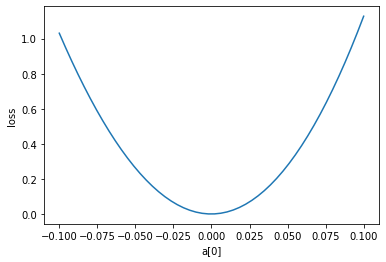

In [6]:
A = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with finite difference derivatives.

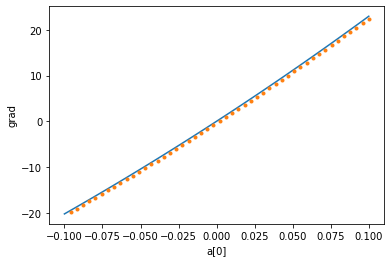

In [7]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.plot(A[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(A[1]-A[0]), '.')
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

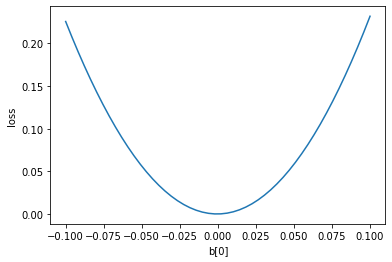

In [8]:
B = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

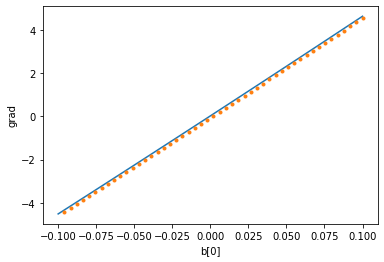

In [9]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.plot(B[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(B[1]-B[0]), '.')
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

[Parameter containing:
tensor([-0.5060], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.1278], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True)]
epoch= 0, loss=290.493911
epoch= 1, loss=255.802669
epoch= 2, loss=178.377162
epoch= 3, loss=28.237060
epoch= 4, loss=16.421205
epoch= 5, loss=29.670853
epoch= 6, loss=3.849046
epoch= 7, loss=14.328390
epoch= 8, loss=2.843278
epoch= 9, loss=2.866596
epoch=10, loss=3.873771
epoch=11, loss=0.373487
epoch=12, loss=0.353020
epoch=13, loss=1.208430
epoch=14, loss=0.273761
epoch=15, loss=0.051077
epoch=16, loss=0.205571
epoch=17, loss=0.122561
Stopping.


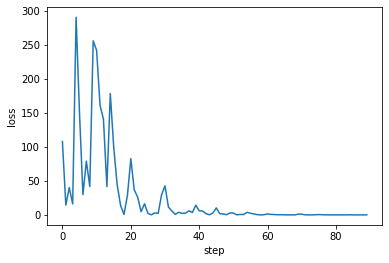

In [5]:
model = AdSBHNet(N=1, std=0.3)

model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
print(list(model.parameters()))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10)

# Training only a and b because this test case doesn't involve the `shift` and `logcoef` parameters.
# optimizer = torch.optim.LBFGS([model.a, model.b])
# epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
epochs = 500

a_vals, b_vals, coef_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()]
losses = []

z = torch.linspace(0, 0.95, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1-z**4
gz0 = 1/fz0

try:
    for epoch in range(epochs):
        for L, V, sigma in loader:
            def closure():
                optimizer.zero_grad()
                V_pred = model(L)
                V_diff = V_pred - V
                loss = torch.mean(V_diff.real**2 / sigma.real) + torch.mean(V_diff.imag**2 / sigma.imag)
                a_vals.append(model.a.detach().numpy().copy())
                b_vals.append(model.b.detach().numpy().copy())
                coef_vals.append(model.logcoef.exp().item())
                loss.backward()
                losses.append(loss.item())
                return loss
            optimizer.step(closure)
        print(f'epoch={epoch:2d}, loss={losses[-1]:0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss');

# Results

The predicted potential in terms of separation.

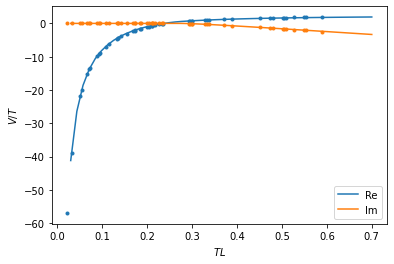

In [6]:
with torch.no_grad():
    L_grid = torch.linspace(0.03, 0.7, 50)
    V_grid = model(L_grid)
plt.plot(L_grid, V_grid.real, label='Re')
plt.plot(L_grid, V_grid.imag, label='Im')
plt.errorbar(dataset.L, dataset.V.real, yerr=dataset.sigma.real, fmt='.', c='C0')
plt.errorbar(dataset.L, dataset.V.imag, yerr=dataset.sigma.imag, fmt='.', c='C1')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.legend();

The complex curve of real $L$.

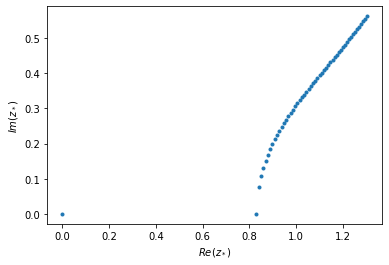

In [7]:
plt.plot([np.real(x) for x in model.curve_zs], [np.imag(x) for x in model.curve_zs], '.')
plt.xlabel(f'$Re(z_*)$')
plt.ylabel(f'$Im(z_*)$');

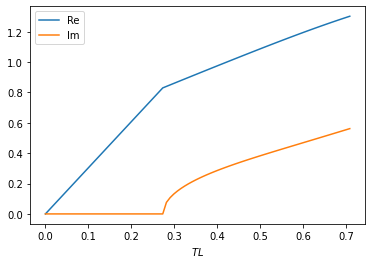

In [8]:
plt.plot(model.curve_L, [np.real(x) for x in model.curve_zs], label='Re')
plt.plot(model.curve_L, [np.imag(x) for x in model.curve_zs], label='Im')
plt.xlabel(f'$T L$')
plt.legend();

Parameter evolution.

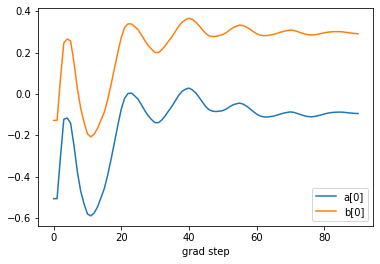

In [9]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend();

Plot the metric functions. This should converge to BH functions.

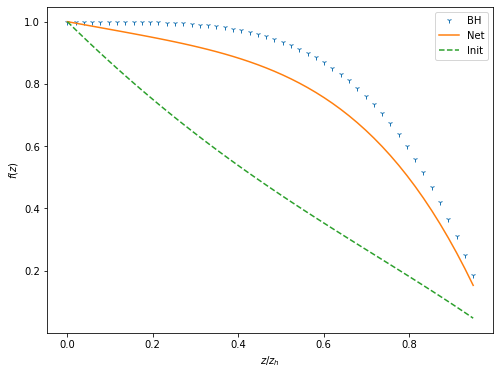

In [10]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$f(z)$')
plt.legend();

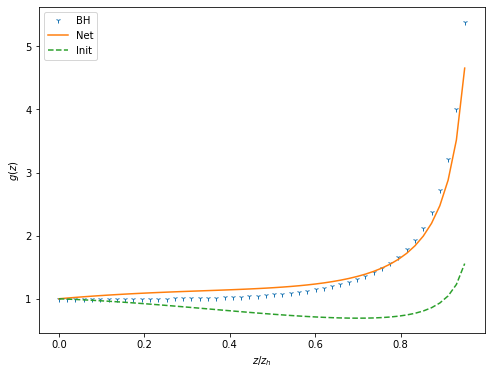

In [11]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$g(z)$')
plt.legend();